## Libraries Used

In [58]:
import pandas as pd
import seaborn as sns
import folium
import json
import matplotlib.pyplot as plt
%matplotlib inline

from branca.colormap import linear

## Functions & Helpers

In [33]:
def save_map(map_name, filename):
    map_filename = "maps/"+filename+".html"
    map_name.save(map_filename)

#Function used to map an array of arcs coordinates to an array of longitude and latitude coordinates
def decodeArc(arcs) :
    x=0;y=0
    conversion = []
    for arc in arcs:
        arc1 = (x + arc[0])*topo_json_data['transform']['scale'][0]+topo_json_data['transform']['translate'][0]
        arc2 = (y + arc[1])*topo_json_data['transform']['scale'][1]+topo_json_data['transform']['translate'][1]
        conversion.append([arc1,arc2])
        x += arc[0]
        y += arc[1]
    return conversion

#Takes an array of arc indices and returns the corresponding array of arcs in longitude/latitude 
#coordinates depending on the shape 
def reconstruct_shape(arcIdx,shape,arcIndices):
    if(shape == 'MultiPolygon') :
        layer1=[]
        for x in range(len(arcs)):
            layer2 = []
            for y in range(len(arcs[x])):
                layer3 = []
                for z in range(len(arcs[x][y])):
                    if(arcs[x][y][z] <0):
                        layer3=layer3 + decodeArc(arcIndices[-arcs[x][y][z]-1])[::-1]
                    else:   
                        layer3=layer3 + decodeArc(arcIndices[arcs[x][y][z]])
                layer2.append(layer3)
            layer1.append(layer2)
        return layer1
    if(shape == 'Polygon') :
        layer1=[]
        for x in range(len(arcs)):
            layer2 = []
            for y in range(len(arcs[x])):
                if(arcs[x][y] <0):
                    layer2=layer2 + decodeArc(arcIndices[-arcs[x][y]-1])[::-1]
                else :   
                    layer2=layer2 + decodeArc(arcIndices[arcs[x][y]])
            layer1.append(layer2)
        return layer1

We choose the linear scale 'GnBu' which is a scale used to represent divergent data using light green colors for weak unemployement rate and dark blue colors for high ones. It also uses colors that can be distinguished by most colorblind people.

In [34]:
#Create colormap
colormap = linear.GnBu.scale(0,10)

colormap

In [35]:
# load the dataset of unemployment rate
unemployment_data = pd.read_excel('data/lfsq_urgan.xls')
unemployment_data.columns = np.append("Unemployment rates by citizenship (%)",unemployment_data.iloc[10][1:])

#We drop useless rows and match country names to the ones in the topojson file
unemployment_data = unemployment_data.drop(np.append(range(0,17),range(50,151)))
unemployment_data = unemployment_data.reset_index(drop=True)
unemployment_data['Unemployment rates by citizenship (%)'][4] = 'Germany'
unemployment_data['Unemployment rates by citizenship (%)'][31] = 'The former Yugoslav Republic of Macedonia'
unemployment_data.head(5)

,Unemployment rates by citizenship (%),2015Q1,2015Q2,2015Q3,2015Q4,2016Q1,2016Q2,2016Q3,2016Q4,2017Q1,2017Q2
0,Belgium,8.8,8.4,8.2,8.7,8.3,7.9,7.9,7.2,7.7,7
1,Bulgaria,10.6,9.9,8.3,7.9,8.6,8.1,7,6.7,6.9,6.3
2,Czech Republic,6,4.9,4.8,4.5,4.4,3.9,4,3.6,3.5,3
3,Denmark,6.6,6,6.2,5.8,6.3,6,6.3,6.1,6.5,5.5
4,Germany,5,4.7,4.4,4.5,4.5,4.2,4,3.8,4.1,3.8


The most recent complete data we could get is for the second quarter of 2017. There was some more recent data yet there were some missing values for certain countries as Switzerland. We can see that we don't have the data for countries outside of the European Union, we will then need to ignore them in the topojson file when creating our map.

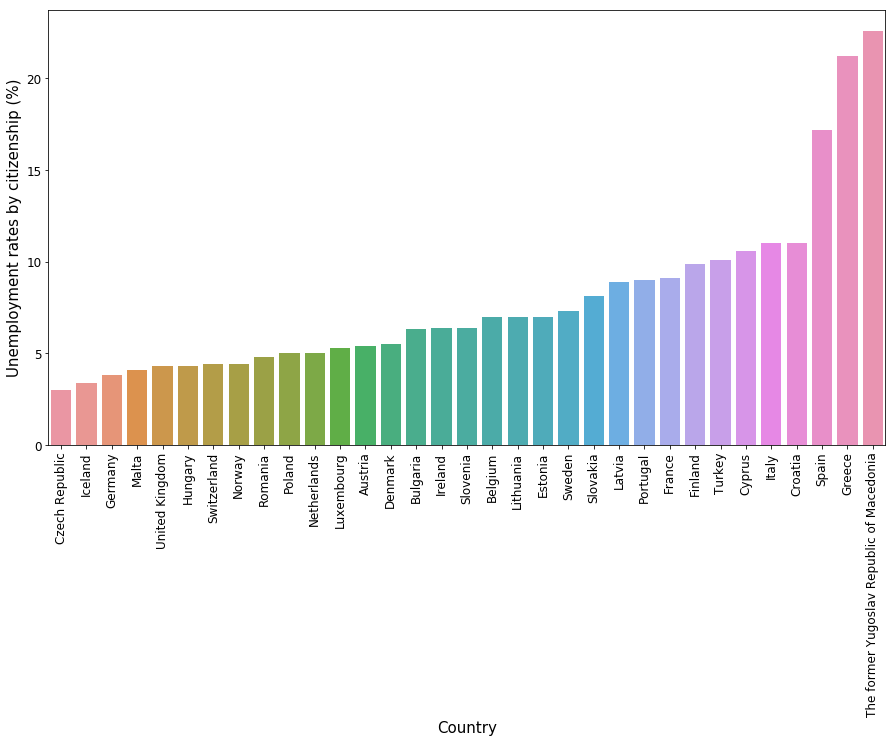

In [36]:
#We can change the period and choose one between the first quarter of 2015 to the second of 2017 here 
#using column names
period = '2017Q2'

#We sort by employement rate for the second quarter of 2017 as it is the most recent data we have 
#for all EU countries and plot it.
unemployment_data = unemployment_data.sort_values(period)
plt.rcParams['figure.figsize']=(15,8)
plt.rcParams["axes.labelsize"] = 15
plot = sns.barplot(y=unemployment_data[period], x=unemployment_data['Unemployment rates by citizenship (%)'])
plot.set_xticklabels(labels =unemployment_data['Unemployment rates by citizenship (%)'] ,rotation=90,  fontsize=12)
plot.set_yticklabels(labels =[0,5,10,15,20] ,fontsize=12)
plot.set_ylabel(ylabel='Unemployment rates by citizenship (%)')
plot.set_xlabel(xlabel='Country')
plt.show()

We can see that most values lie between 3% and 12% so we will create our scale so it is more precise (i. e. more interval classes) for these values.

In [37]:
#creation of interval classes
threshold_scale=[3, 6, 10, 12, 23]

#returns unemployment rate for a given country name if available
def printCountry(state):
    if(state in unemployment_data['Unemployment rates by citizenship (%)'].tolist()):
        return colormap(unemployment_data['2017Q2'][unemployment_data['Unemployment rates by citizenship (%)'].tolist().index(state)])
    else: print(state)


In [38]:
#loading topojson data and getting the array of all arcs in the json.
topo_json_data = json.load(open(r'topojson/europe.topojson.json'))
arcIndices = topo_json_data['arcs']

#Create the original map using folium
m_eu = folium.Map([52,10], tiles='cartodbpositron', zoom_start=4)

#Deletion of the entries corresponding to non-eu countries
topo_json_data = json.load(open(r'topojson/europe.topojson.json'))
offset = 0
for c in range(len(topo_json_data['objects']['europe']['geometries'])):
    if(topo_json_data['objects']['europe']['geometries'][c-offset]['properties']['NAME'] not in unemployment_data['Unemployment rates by citizenship (%)'].tolist()):
        del topo_json_data['objects']['europe']['geometries'][c-offset]
        offset+=1

#Adding choropleth to the map using our unemployment data for the second quarter of 2017, topojson and colormap
m_eu.choropleth(geo_data=topo_json_data, data=unemployment_data,
                key_on='properties.NAME',
                threshold_scale=threshold_scale,
                columns=['Unemployment rates by citizenship (%)',period],
                fill_color='GnBu', fill_opacity=1, line_opacity=0.5,
                legend_name='Percentage of unemployment per country (%) (2nd quarter of 2017)',
                topojson='objects.europe')


#For every country we recontruct the shape of the country in order to create a clickable marker of the same shape and 
#if the country is in our data frame we display its name and unemployment rate.
for country in topo_json_data['objects']['europe']['geometries']:
    shape = country['type']
    arcs = country['arcs']
    gj = folium.GeoJson(
        data={
            'type': shape,
            'coordinates': reconstruct_shape(arcs,shape,arcIndices)
        }, style_function=  lambda x: {'fillColor': 'white',
                                       'opacity': 0,
                                       'color': 'white',
                                       'fillOpacity': 0},
    )
    try:
        gj.add_child(folium.Popup(country['properties']['NAME']+': '+repr(unemployment_data.set_index('Unemployment rates by citizenship (%)')[period][country['properties']['NAME']])+'%'))
    except KeyError:
        gj.add_child(folium.Popup((country['properties']['NAME']+': unkown')))
    gj.add_to(m_eu)
    
save_map(m_eu,"task1")

<a href="maps/task1.html">Task 1 - Map 1</a>

<h5>To visualize our map, please follow the following link:</h5>

<br>&emsp;<a href="https://sanadhis.github.io/ITT-ADA-2017/03%20-%20Interactive%20Viz/maps/task1.html" target="_blank">Task 1 - Map 1</a>

As we can see Switzerland is doing well compared to other countries in Europe as its unemployment rate is of only 4.4% for the second quarter of 2017. Therefore Switzerland belongs to the lowest interval class as well as countries from the center of Europe such as Germany or Austria, it is ranked 7th in terms of lowest unemployment rate for this period.

# 2. Analyzing Unemployment Rate in Switzerland with Amstat Dataset
For analyzing unemployement rates in Switzerland, we use dataset provided by <a href="https://www.amstat.ch/v2/index.jsp">Amstat.ch</a>. 

* <i>Note that we opt to use the dataset of September 2017 since it is the most recent data available in Amstat</i>.

We also use the provided definitions <a href="https://www.amstat.ch/v2/definition.jsp?lang=fr">here</a> and pay attention into three categories of unemployment:
* Registered unemployed (“Chômeurs inscrits”)
* Registered jobseekers (“Demandeurs d'emploi inscrits”)
* Registered employed jobseekers (“Demandeurs d'emploi inscrits non-chômeurs”)

In addition into these three categories, Amstat also provide us with "Unemployment Rate" which quantifies the number of people looking for a job divided by the size of the active population (scaled by 100). 

Thus, using these four data, we can analyze the unemployment rates in Switzerland by cantons. 

## 2.1 Read data from the dataset
As we have described above, we make use only <b>"unemployment_rate"</b>, <b>"registered_unemployed"</b>, <b>"registered_jobseekers"</b>, <b>"registered_employed_jobseekers"</b> of each canton. These columns are columns <b>2,4,5,6</b> in our excel dataset file.

In [39]:
amstat_dataset  = "data/amstat-unemployment_rate.xlsx"

# use of columns: [0=canton, 2=unemployment_rate, 4=registered_unemployed, 
# 5=registered_jobseekers, 6=registered_employed_jobseekers]
columns         = [0, 2, 4, 5, 6]
columns_name    = ["canton", 
                   "unemployment_rate", 
                   "registered_unemployed", 
                   "registered_jobseekers", 
                   "registered_employed_jobseekers"]

# Read throught dataset file. Remove title, headers in first three rows and total entries in the last row.
amstat_unemployment_data                      = pd.read_excel(amstat_dataset, skiprows=[0,1,2], 
                                                              skip_footer=1, usecols=columns)

# Change columns name from French to English ones
amstat_unemployment_data.columns              = columns_name

# Display first 5 entries
amstat_unemployment_data.head(5)

,canton,unemployment_rate,registered_unemployed,registered_jobseekers,registered_employed_jobseekers
0,Zürich,3.3,27225,34156,6931
1,Bern,2.4,13658,18385,4727
2,Luzern,1.7,3885,6756,2871
3,Uri,0.6,112,257,145
4,Schwyz,1.7,1455,2229,774


Next, we replace cantons' name in column canton with canton ids (ZH=Zurich, BE=Bern, and so on). We perform this in order to be able to utilize the <b>ch-cantons.topojson.json</b> later for map properties.

In [40]:
# Define each canton id respectively 
cantonIds = pd.Series(['ZH', 'BE', 'LU', 'UR', 'SZ', 'OW', 'NW', 'GL', 'ZG', 'FR', 'SO', \
                       'BS', 'BL', 'SH', 'AR', 'AI', 'SG', 'GR', 'AG', 'TG', 'TI', 'VD', \
                       'VS', 'NE', 'GE', 'JU'])

# Replace cantons' name with their ids accordingly
amstat_unemployment_data['canton'] = cantonIds

# Display first 5 entries
amstat_unemployment_data.head(5)

,canton,unemployment_rate,registered_unemployed,registered_jobseekers,registered_employed_jobseekers
0,ZH,3.3,27225,34156,6931
1,BE,2.4,13658,18385,4727
2,LU,1.7,3885,6756,2871
3,UR,0.6,112,257,145
4,SZ,1.7,1455,2229,774


## 2.2 Maps

To draw clear boundaries between cantons, we use the provided <b>ch-cantons.topojson.json</b> as the overlays.
<br>We define the basic map of Switzerland with exact cantons borders as <b>basic_map_ch</b>. Using this, we create more visual maps to describe unemployment rates in Switzerland

In [41]:
ch_coordinate     = [46.9, 8.3]
cantons_json_data = json.load(open(r'topojson/ch-cantons.topojson.json'))


### Map 1: Showing Unemployment Rates using unemployment_rate from Amstat
For this part, we shows how unemployment_rate from Amstat describe unemployment accross Switzerland

In [42]:
map_ch = folium.Map(location = ch_coordinate, tiles='cartodbpositron', zoom_start=8)

folium.TopoJson(open(r'topojson/ch-cantons.topojson.json'), 'objects.cantons').add_to(map_ch)

map_ch.choropleth(
                geo_data     = cantons_json_data, 
                data         = amstat_unemployment_data,
                columns      = ['canton','unemployment_rate'],
                key_on       = 'id',
                fill_color   = 'GnBu', 
                fill_opacity = 1, 
                line_opacity = 0.5,
                legend_name  = 'Rate of unemployment per canton (%) (September 2017)',
                topojson     = 'objects.cantons'
                )

arcIndices = cantons_json_data['arcs']
for canton in cantons_json_data['objects']['cantons']['geometries']:
    shape = canton['type']
    arcs = canton['arcs']
    gj = folium.GeoJson(
        data={
            'type': shape,
            'coordinates': reconstruct_shape(arcs,shape,arcIndices)
        }, style_function=  lambda x: {'fillColor': 'white',
                                       'opacity': 0,
                                       'color': 'white',
                                       'fillOpacity': 0}
    )
    try:
        gj.add_child(folium.Popup(canton['properties']['name']+': '+ '%.2f' % (amstat_unemployment_data.set_index('canton')['unemployment_rate'][canton['id']])+'%'))
    except KeyError:
        gj.add_child(folium.Popup((canton['properties']['name']+': unkown')))
    gj.add_to(map_ch)

save_map(map_ch,"task2_1")

Please follow this link to view the result map in nice HTML page:
<br><a href="maps/task2_1.html">Map 2 - 1</a>

<h5>To visualize our map, please follow the following link:</h5>

<br>&emsp;<a href="https://sanadhis.github.io/ITT-ADA-2017/03%20-%20Interactive%20Viz/maps/task2_1.html" target="_blank">Task 2 - Map 1</a>

### Map 2: Showing Unemployment Rates based on Total Jobseekers
As we have mentioned that Amstat defines "Registered Jobseekers" / Demandeurs d'emploi as total Jobseekers per canton, thus we assume this is equal to the sum of unemployed people and employed jobseekers.

In [43]:
map_ch = folium.Map(location = ch_coordinate, tiles='cartodbpositron', zoom_start=8)

folium.TopoJson(open(r'topojson/ch-cantons.topojson.json'), 'objects.cantons').add_to(map_ch)

map_ch.choropleth(
                geo_data     = cantons_json_data, 
                data         = amstat_unemployment_data,
                columns      = ['canton','registered_jobseekers'],
                key_on       = 'id',
                fill_color   = 'GnBu', 
                fill_opacity = 1, 
                line_opacity = 0.5,
                legend_name  = 'Number of Jobseekers (September 2017)',
                topojson     = 'objects.cantons'
                )

arcIndices = cantons_json_data['arcs']
for canton in cantons_json_data['objects']['cantons']['geometries']:
    shape = canton['type']
    arcs = canton['arcs']
    gj = folium.GeoJson(
        data={
            'type': shape,
            'coordinates': reconstruct_shape(arcs,shape,arcIndices)
        }, style_function=  lambda x: {'fillColor': 'white',
                                       'opacity': 0,
                                       'color': 'white',
                                       'fillOpacity': 0}
    )
    try:
        gj.add_child(folium.Popup(canton['properties']['name']+': '+ str(amstat_unemployment_data.set_index('canton')['registered_jobseekers'][canton['id']])))
    except KeyError:
        gj.add_child(folium.Popup((canton['properties']['name']+': unkown')))
    gj.add_to(map_ch)

save_map(map_ch,"task2_2")

Please follow this link to view the result map in nice HTML page:
<br><a href="maps/task2_2.html">Map 2 - 2</a>

<h5>To visualize our map, please follow the following link:</h5>

<br>&emsp;<a href="https://sanadhis.github.io/ITT-ADA-2017/03%20-%20Interactive%20Viz/maps/task2_2.html" target="_blank">Task 2 - Map 2</a>

### Map 3: Showing Unemployment Rates by Excluding People who already have a job and are looking for a new one
For this part, we exclude "Registered Employed Jobseekers" since we want to account only unemployed people. Therefore, we map only "registered_unemployed" for this part.

In [69]:
map_ch = folium.Map(location = ch_coordinate, tiles='cartodbpositron', zoom_start=8)

folium.TopoJson(open(r'topojson/ch-cantons.topojson.json'), 'objects.cantons').add_to(map_ch)

map_ch.choropleth(
                geo_data     = cantons_json_data, 
                data         = amstat_unemployment_data,
                columns      = ['canton','registered_unemployed'],
                key_on       = 'id',
                fill_color   = 'GnBu', 
                fill_opacity = 1, 
                line_opacity = 0.5,
                legend_name  = 'Number of Unemployed Jobseekers(September 2017)',
                topojson     = 'objects.cantons'
                )

arcIndices = cantons_json_data['arcs']
for canton in cantons_json_data['objects']['cantons']['geometries']:
    shape = canton['type']
    arcs = canton['arcs']
    gj = folium.GeoJson(
        data={
            'type': shape,
            'coordinates': reconstruct_shape(arcs,shape,arcIndices)
        }, style_function=  lambda x: {'fillColor': 'white',
                                       'opacity': 0,
                                       'color': 'white',
                                       'fillOpacity': 0}
    )
    try:
        gj.add_child(folium.Popup(canton['properties']['name']+': '+ str(amstat_unemployment_data.set_index('canton')['registered_unemployed'][canton['id']])))
    except KeyError:
        gj.add_child(folium.Popup((canton['properties']['name']+': unkown')))
    gj.add_to(map_ch)

save_map(map_ch,"task2_3")

Please follow this link to view the result map in nice HTML page:
<br><a href="maps/task2_3.html">Map 2 - 3</a>

<h5>To visualize our map, please follow the following link:</h5>

<br>&emsp;<a href="https://sanadhis.github.io/ITT-ADA-2017/03%20-%20Interactive%20Viz/maps/task2_3.html" target="_blank">Task 2 - Map 3</a>

# Part3

Decription of dataset of unemployment rate
We use the dataset with the following attributes:
1. Unemployment rate indicators - Unemployment rate
2. Unemployed indicators - Registered unemployed
3. Geographical features - Canton
4. Other attributes - Nationality
5. Date - September, 2017

<br>
Based on the definition in amstat, registered unemployed is the people advertised at regional employment agencies, who are unemployed and immediately available for placement. It does not matter whether they are receiving unemployment benefits or not. This attribute shows the people who don't have a job and intend to get a job as soon as possible, and hence we think it's the best attribute we want to know.
<br><br>
And because the assignment asks us to choose recent date, we choose the most recent one: September 2017. In our opinion, we only consider the "current" situation in the aspect of unemployment rate. Unemployment rate is not like temperature, it makes no sense to take the average or median of the unemployment rate. For example, if you choose unemployment rate of 6 months (e.g. from April to September) and you find the median of unemployment rate as your reference, and it would be unreasonable because you may calculate the difference between the unemployment rate of foreigners in April and the unemployment rate of Swiss in July as your result.

### Load the dataset of unemployment rate and preprocess

In [59]:
# load the dataset of unemployment rate
unemployment_data = pd.read_excel('data/2017_09_nationality.xlsx')

unemployment_data = unemployment_data.drop(0)
unemployment_data = unemployment_data.drop(['Mois', 'Total'], axis = 1)

unemployment_data=unemployment_data.rename(columns = {'Septembre 2017':'Unemployment_Rate'})


unemployment_data['Unemployment_Rate'] = unemployment_data['Unemployment_Rate'].astype(float)
unemployment_data_foreigner = unemployment_data[unemployment_data['Nationalité'] == 'Etrangers']
unemployment_data_suisse = unemployment_data[unemployment_data['Nationalité'] == 'Suisses']

unemployment_data_foreigner = unemployment_data_foreigner.reset_index(drop=True)
unemployment_data_suisse = unemployment_data_suisse.reset_index(drop=True)


cantonNames = pd.Series(['ZH', 'BE', 'LU', 'UR', 'SZ', 'OW', 'NW', 'GL', 'ZG', 'FR', 'SO', \
                        'BS', 'BL', 'SH', 'AR', 'AI', 'SG', 'GR', 'AG', 'TG', 'TI', 'VD', 'VS', 'NE', 'GE', 'JU'])
unemployment_data_foreigner['Canton_Short'] = cantonNames
unemployment_data_suisse['Canton_Short'] = cantonNames

# show how the current dataframe looks like
unemployment_data_foreigner.head(5)

,Canton,Nationalité,Unemployment_Rate,Canton_Short
0,Zurich,Etrangers,5.3,ZH
1,Berne,Etrangers,5.5,BE
2,Lucerne,Etrangers,3.9,LU
3,Uri,Etrangers,2.1,UR
4,Schwyz,Etrangers,3.4,SZ


### 3.1 Show the difference of unemployment rate for each canton
First we observe that all unemployment rate of foreigners are higher than that of swiss, and hence, it's reasonable to show the result by unemployment_rate_foreigner - nemployment_rate_swiss

In [60]:
# to show that it's true that unemployment rate of foreigners are higher than that of swiss
all(unemployment_data_foreigner['Unemployment_Rate'] > unemployment_data_suisse['Unemployment_Rate'])

True

In [61]:
# calculate the difference of unemployment rate
unemployment_data_foreigner['Diff_With_Swiss'] = unemployment_data_foreigner['Unemployment_Rate'] - \
                                                 unemployment_data_suisse['Unemployment_Rate']
unemployment_data_foreigner.head(4)

,Canton,Nationalité,Unemployment_Rate,Canton_Short,Diff_With_Swiss
0,Zurich,Etrangers,5.3,ZH,2.8
1,Berne,Etrangers,5.5,BE,3.7
2,Lucerne,Etrangers,3.9,LU,2.6
3,Uri,Etrangers,2.1,UR,1.7


### Choropleth map with diverging colormap
Reason: This kind of color map uses two more distinct colors for minimum and maximum values, which improves the drawback of sequential color map. We know sequential colormap only use one color and it's easy to make users confused. Although quantized mapping is very clear in the aspect of coloar, we think too many colors also make it difficult on understanding too.

Furthermore, we set fill_opacity = 1 to make the colors more distinguishable and use interactive map to show the name of canton and unemployment rate

![Sequential Colormap](figure/sequential.png)

![Diverging Colormap](figure/diverging.png)

![Quantized Coloarmap](figure/quantized.png)

[Reference](http://www.kennethmoreland.com/color-maps/ColorMapsExpanded.pdf)

In [70]:
# create the map of Switzerland
suisse_coord = [46.9, 8.3]
map_suisse = folium.Map(location = suisse_coord, 
                         tiles = 'cartodbpositron',
                         zoom_start = 8)

# import the topo json file
topo_path = r'topojson/ch-cantons.topojson.json'
topo_json_data = json.load(open(topo_path))

# add the topo to the map and show the result
folium.TopoJson(open(topo_path), 'objects.cantons').add_to(map_suisse)

map_suisse.choropleth(geo_data    = topo_json_data, 
                  data        = unemployment_data_foreigner,
                  columns     = ['Canton_Short', 'Diff_With_Swiss'],
                  key_on      = 'id',
                  fill_color  = 'GnBu', fill_opacity=1, line_opacity=0.3,
                  topojson    = 'objects.cantons',
                  legend_name = 'Unemployment Rate')

arcIndices = topo_json_data['arcs']
for country in topo_json_data['objects']['cantons']['geometries']:
    shape = country['type']
    arcs = country['arcs']
    gj = folium.GeoJson(
        data={
            'type': shape,
            'coordinates': reconstruct_shape(arcs,shape,arcIndices)
        }, style_function=  lambda x: {'fillColor': 'white',
                                       'opacity': 0,
                                       'color': 'white',
                                       'fillOpacity': 0}
    )
    try:
        gj.add_child(folium.Popup(country['properties']['name'] + ": " + \
                                 '%.2f' % round(unemployment_data_foreigner.set_index('Canton_Short').loc[country['id']][3],1) + '%'))
    except KeyError:
        gj.add_child(folium.Popup((country['properties']['name']+': unkown')))
    gj.add_to(map_suisse)

save_map(map_suisse,"task3")

<

<h5>To visualize our map, please follow the following link:</h5>

<br>&emsp;<a href="https://sanadhis.github.io/ITT-ADA-2017/03%20-%20Interactive%20Viz/maps/task3.html" target="_blank">Task 3</a>

### 3.2 Adding the differences between age groups and show it by bar plot
To do this, we need another dataset:
### Decription of dataset of number of unemployed by age and nationality
We use the dataset with the following attributes:
1. Unemployed indicators        - Registered unemployed
2. Geographical features        - Canton
3. General characteristic       - Nationality & Age class {15 - 24, 25 - 49, 50 and over}
4. Date                         - September, 2017

In this dataset, it shows the number of unemployed rather than the unemployment rate. However, combined with the dataframe in 3.1, we can easily calculate the unemployment rate in each (nationality, age) class. For example, we can get the unemployment rate of foreigners 6% from the previous dataframe, and based on this current dataframe, we know the number of unemployed foriegners in {15 - 24, 25 - 49, 50 and over} are 100, 200, 300 respectively, so we can find the unemployment rate of foreigners in {15 - 24, 25 - 49, 50 and over} are 1%, 2%, 3% respectively.

### Load the dataset and preprocess

In [63]:
# load the dataset of unemployment rate
unemployment_data_age_nationality = pd.read_excel('data/2017_09_age_nationality.xlsx')


unemployment_data_age_nationality = unemployment_data_age_nationality.drop(0)
unemployment_data_age_nationality = unemployment_data_age_nationality.drop(['Mois', "Classes d'âge 15-24, 25-49, 50 ans et plus"], axis = 1)

unemployment_data_age_nationality = unemployment_data_age_nationality.rename(columns = {'Septembre 2017':'Unemployment_Number'})
unemployment_data_age_nationality = unemployment_data_age_nationality.rename(columns = {'Unnamed: 3':'Age Category'})

unemployment_data_age_nationality = unemployment_data_age_nationality.dropna()

unemployment_data_age_nationality['Unemployment_Number'] = unemployment_data_age_nationality['Unemployment_Number'].astype('int')

# show how the dataset looks like
unemployment_data_age_nationality.head(12)


,Canton,Nationalité,Age Category,Unemployment_Number
1,Zurich,Etrangers,15-24 ans,1015
2,Zurich,Etrangers,25-49 ans,8846
3,Zurich,Etrangers,50 ans et plus,2250
5,Zurich,Suisses,15-24 ans,2405
6,Zurich,Suisses,25-49 ans,8207
7,Zurich,Suisses,50 ans et plus,4502
10,Berne,Etrangers,15-24 ans,597
11,Berne,Etrangers,25-49 ans,3316
12,Berne,Etrangers,50 ans et plus,987
14,Berne,Suisses,15-24 ans,1406


### Calculate the unemployment rate

In [64]:
total_unemployed_number = unemployment_data_age_nationality.groupby(['Canton', 'Nationalité']).sum()
unemployment_rate = unemployment_data.set_index(['Canton', 'Nationalité'])

unemployment_data_age_nationality['Unemployment_Rate'] = \
[element.Unemployment_Number * unemployment_rate.loc[element.Canton, element.Nationalité][0] \
 /total_unemployed_number.loc[element.Canton, element.Nationalité][0] \
 for idx, element in unemployment_data_age_nationality.iterrows()]

unemployment_data_age_nationality.head(12)

,Canton,Nationalité,Age Category,Unemployment_Number,Unemployment_Rate
1,Zurich,Etrangers,15-24 ans,1015,0.444183
2,Zurich,Etrangers,25-49 ans,8846,3.871175
3,Zurich,Etrangers,50 ans et plus,2250,0.984642
5,Zurich,Suisses,15-24 ans,2405,0.397810
6,Zurich,Suisses,25-49 ans,8207,1.357516
7,Zurich,Suisses,50 ans et plus,4502,0.744674
10,Berne,Etrangers,15-24 ans,597,0.670102
11,Berne,Etrangers,25-49 ans,3316,3.722041
12,Berne,Etrangers,50 ans et plus,987,1.107857
14,Berne,Suisses,15-24 ans,1406,0.288970


### Show the result in bar chart

In [65]:
# the function to be used for bar plot
def getData(age_class, nationality):
    condition = (unemployment_data_age_nationality['Age Category'] == age_class) & (unemployment_data_age_nationality['Nationalité'] == nationality)
    return unemployment_data_age_nationality[condition]

def plot_(data, title):
    fig, ax = plt.subplots()
    fig.set_size_inches(12, 5)
    ax1 = sns.barplot(x = data.Canton , y = data.Unemployment_Rate, ax = ax, ci = None)
    ax1.set_xticklabels(ax.get_xticklabels(), rotation = 90)
    ax1.set_title(title)

    return ax1

### age 15 - 24 

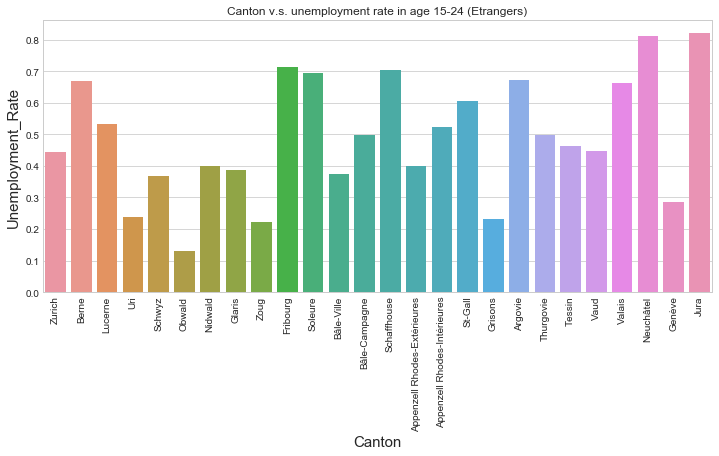

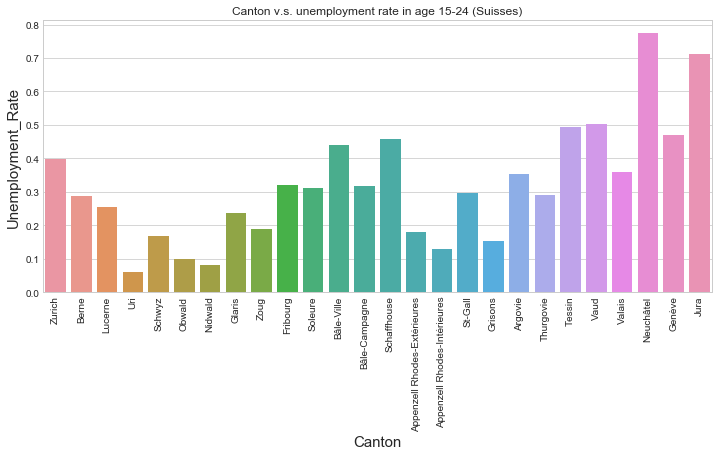

In [66]:
sns.set_style("whitegrid")

data = getData('15-24 ans', 'Etrangers')
plot_(data, 'Canton v.s. unemployment rate in age 15-24 (Etrangers)')

data = getData('15-24 ans', 'Suisses')
plot_(data, 'Canton v.s. unemployment rate in age 15-24 (Suisses)')

### age 25-49

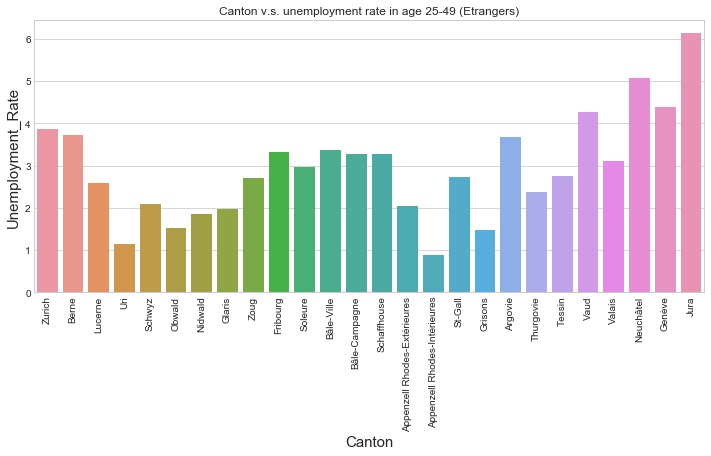

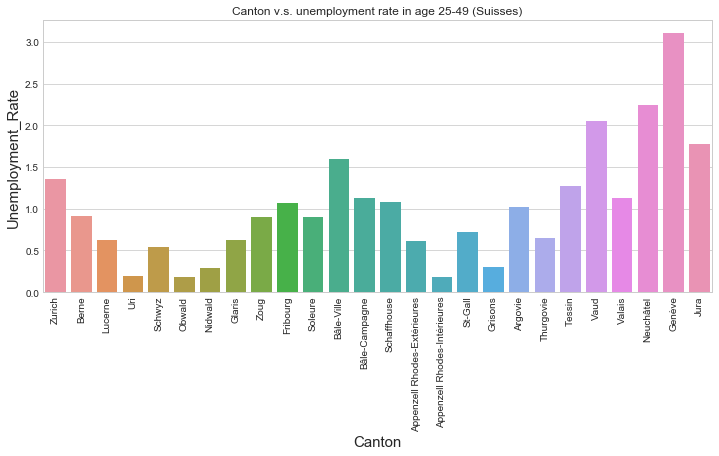

In [67]:
data = getData('25-49 ans', 'Etrangers')
plot_(data, 'Canton v.s. unemployment rate in age 25-49 (Etrangers)')

data = getData('25-49 ans', 'Suisses')
plot_(data, 'Canton v.s. unemployment rate in age 25-49 (Suisses)')

### age 50 up

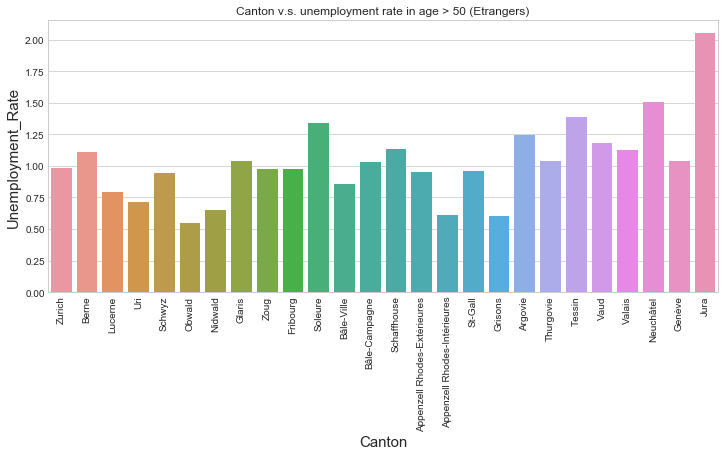

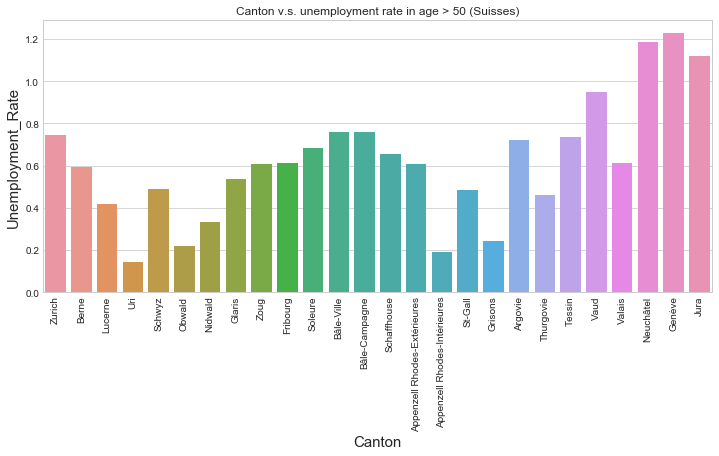

In [68]:
data = getData('50 ans et plus', 'Etrangers')
plot_(data, 'Canton v.s. unemployment rate in age > 50 (Etrangers)')

data = getData('50 ans et plus', 'Suisses')
plot_(data, 'Canton v.s. unemployment rate in age > 50 (Suisses)')